In [9]:
# Import necessary libraries for data handling, model utilization, and visualization
import numpy as np
import pandas as pd
import yfinance as yf  # For collecting financial data
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize 
from datetime import datetime, timedelta
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from collections import deque
# Import the custom Model class
from Model import Model

# Set the random seed for reproducibility across numpy and tensorflow
np.random.seed(123)

plt.style.use('seaborn-darkgrid')

# Define the tickers and date range with consideration of trading days
TICKERS = ['AGG','DBC','VTI','^VIX']

# Approximate number of trading days per year (useful for annualizing returns)
TRADING_DAYS_PER_YEAR = 252

# Confirm setup
print("Setup complete: libraries imported, random seed set, and tickers defined.")


Setup complete: libraries imported, random seed set, and tickers defined.


/var/folders/60/5d3h4l453h9ccqs1c1vsm1qr0000gn/T/ipykernel_7670/1997288386.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [10]:
# Data Collection Step
# Objective: Fetch historical adjusted close prices for defined tickers and date range

# Download data using yfinance for the specified tickers and date range
def get_data(tickers, start_date, end_date):
    """
    Retrieves historical adjusted close prices for the given tickers and date range.
    
    Parameters:
    - tickers: List of stock ticker symbols
    - start_date: Start date for historical data
    - end_date: End date for historical data
    
    Returns:
    - DataFrame of adjusted close prices, with each column representing a ticker
    """
    # Fetch data from yfinance
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    
    # Drop rows with missing values, if any, to ensure data continuity
    data.dropna(inplace=True)
    
    return data

# Fetch the data and display a quick preview
data = get_data(TICKERS, '2000-01-01', '2021-01-04')
print("Data fetched successfully. Sample data:")
print(data.head())

# Confirm data spans the expected range and has the expected number of columns
print(f"Data covers {len(data)} trading days with {len(data.columns)} assets.")


[*********************100%***********************]  4 of 4 completed


Data fetched successfully. Sample data:
Ticker                           AGG        DBC        VTI   ^VIX
Date                                                             
2006-02-06 00:00:00+00:00  56.124348  20.889496  44.654266  13.04
2006-02-07 00:00:00+00:00  56.085159  20.285255  44.219505  13.59
2006-02-08 00:00:00+00:00  56.057137  20.198936  44.537636  12.83
2006-02-09 00:00:00+00:00  56.090797  20.388840  44.452789  13.12
2006-02-10 00:00:00+00:00  55.973137  20.017662  44.544697  12.87
Data covers 3753 trading days with 4 assets.


In [11]:
def calculate_annualized_volatility(price_data):
    log_returns = np.log(price_data / price_data.shift(1))
    daily_volatility = log_returns.std()
    annualized_volatility = daily_volatility * np.sqrt(TRADING_DAYS_PER_YEAR)
    return annualized_volatility

In [12]:
def determine_target_volatility(ticker, start_date, end_date, percentage_of_benchmark=0.8):
    price_data = get_data(ticker, start_date, end_date)
    benchmark_volatility = calculate_annualized_volatility(price_data)
    if isinstance(benchmark_volatility, pd.Series):
        benchmark_volatility = benchmark_volatility.iloc[0]
        
    target_volatility = benchmark_volatility * percentage_of_benchmark
    return ticker, benchmark_volatility * 100, target_volatility * 100

In [13]:
volatility_data = []

for ticker in TICKERS:
    ticker, benchmark_vol, target_vol = determine_target_volatility(ticker, '2010-01-01', '2020-01-01', 0.8)
    volatility_data.append({
        'Ticker': ticker,
        'Benchmark Volatility (%)': benchmark_vol,
        'Target Volatility (%)': target_vol
    })

volatility_df = pd.DataFrame(volatility_data)
volatility_df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Ticker,Benchmark Volatility (%),Target Volatility (%)
0,AGG,3.235540,2.588432
1,DBC,15.687101,12.549681
2,VTI,15.029555,12.023644
3,^VIX,122.819360,98.255488


In [14]:
def preprocess_data(data, rolling_window=50):
    """
    Prepares data by calculating 50-day rolling averages and returns.

    Parameters:
    - data: DataFrame of historical adjusted close prices for assets
    - rolling_window: Window size for the rolling average

    Returns:
    - normalized_data: Smoothed prices, normalized to start at 1 for each asset
    - returns: Smoothed returns using a rolling mean of percentage changes
    """
    # Calculate rolling mean for prices and returns to smooth the data
    smoothed_prices = (data.rolling(window=rolling_window).mean()).dropna()
    smoothed_returns = (data.pct_change().rolling(window=rolling_window).mean()).dropna()
    # Normalize prices to start each asset's time series at 1
    normalized_data = smoothed_prices / smoothed_prices.iloc[0]
    
    return normalized_data, smoothed_returns


# Run preprocessing and display sample data
normalized_data, smoothed_returns = preprocess_data(data)
print("Data preprocessing complete. Sample normalized data:")
print(normalized_data.head())
print("\nSample daily returns:")
print(smoothed_returns.head())


Data preprocessing complete. Sample normalized data:
Ticker                          AGG       DBC       VTI      ^VIX
Date                                                             
2006-04-18 00:00:00+00:00  1.000000  1.000000  1.000000  1.000000
2006-04-19 00:00:00+00:00  0.999786  1.001443  1.000798  0.997130
2006-04-20 00:00:00+00:00  0.999555  1.003226  1.001815  0.993875
2006-04-21 00:00:00+00:00  0.999332  1.005552  1.002683  0.991806
2006-04-24 00:00:00+00:00  0.999172  1.007249  1.003528  0.989520

Sample daily returns:
Ticker                          AGG       DBC       VTI      ^VIX
Date                                                             
2006-04-19 00:00:00+00:00 -0.000212  0.001441  0.000813 -0.001952
2006-04-20 00:00:00+00:00 -0.000229  0.001788  0.001035 -0.002230
2006-04-21 00:00:00+00:00 -0.000221  0.002295  0.000882 -0.001198
2006-04-24 00:00:00+00:00 -0.000157  0.001709  0.000862 -0.001374
2006-04-25 00:00:00+00:00 -0.000182  0.002136  0.000757 -0.000993


In [15]:
class Portfolio:
    def __init__(self, initial_cash: float, assets: pd.DataFrame):
        """
        Initializes the Portfolio object.

        Parameters:
        - initial_cash: The starting value of the portfolio in cash.
        - assets: DataFrame of asset prices (historical data).
        """
        self.initial_cash = initial_cash
        self.current_value = initial_cash
        self.assets = assets  # Historical price data for the assets
        self.weights = np.zeros(len(assets.columns))  # Initialize weights as zero
        self.portfolio_history = []  # To track portfolio value over time
        self.rebalancing_dates = []  # To store rebalancing dates

    def rebalance(self, new_weights: np.array, target_volatility = None):
        """
        Rebalances the portfolio according to new weights.

        Parameters:
        - new_weights: Numpy array of asset allocations.
        """
        if len(new_weights) != len(self.assets.columns):
            raise ValueError("Number of weights must match the number of assets.")
        self.weights = new_weights
        if target_volatility is not None:
            self.volatility_scaling(target_volatility=target_volatility, lambda_decay=0.94)

    def calculate_initial_shares(self, initial_cash, initial_prices):
        """
        Calculates the number of shares for each asset at the start of the testing period based on
        initial cash and allocation weights.

        Parameters:
        - initial_cash: The starting cash value of the portfolio.

        Returns:
        - shares: Dictionary with tickers as keys and the initial number of shares as values.
        """
        # Calculate the dollar amount allocated to each asset
        dollar_allocation = initial_cash * self.weights

        # Calculate the number of shares for each asset
        shares = (dollar_allocation // initial_prices).astype(int)  # Floor division to get whole shares

        # Return as a dictionary for easy readability
        return dict(zip(self.assets.columns, shares))
    
    def calculate_daily_returns(self):
        """
        Applies the current weights to asset returns and updates portfolio value over time.
        """
        # Calculate daily returns for each asset
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate portfolio returns by applying weights
        portfolio_returns = np.dot(daily_returns, self.weights)

        # Track the portfolio's value over time by compounding the returns
        for daily_ret in portfolio_returns:
            self.current_value *= (1 + daily_ret)
            self.portfolio_history.append(self.current_value)

    def update_portfolio_value(self, date):
        """
        Updates the portfolio value for a single date.
        """
        # Get the index of the date
        date_index = self.assets.index.get_loc(date)
        if date_index == 0:
            # First day, no previous day to compute return
            self.portfolio_history.append(self.current_value)
            return
        # Get the asset returns for that day
        previous_date = self.assets.index[date_index - 1]
        daily_return = self.assets.loc[date] / self.assets.loc[previous_date] - 1
        # Calculate portfolio return
        portfolio_return = np.dot(daily_return.values, self.weights)
        # Update portfolio value
        self.current_value *= (1 + portfolio_return)
        # Append to history
        self.portfolio_history.append(self.current_value)


    def track_portfolio_performance(self):
        """
        Tracks and prints the portfolio performance over time.
        """
        for date, value in zip(self.assets.index[1:], self.portfolio_history):
            print(f"Date: {date}, Portfolio Value: {value}")
    
    def reset(self):
        self.current_cash = self.initial_cash
        self.assets = self.initial_assets.copy()
        self.weights = np.zeros(len(self.assets.columns))  # Reset to no investments
        self.portfolio_history = []
        self.rebalancing_dates = []
        return self.assets.iloc[0].values

    def get_portfolio_value(self):
        """
        Returns the current value of the portfolio.
        """
        return self.current_value
    
    def plot_portfolio_value(self):
        """
        Plots the portfolio value over time.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.assets.index[1:], self.portfolio_history, label="Portfolio Value")
        plt.title("Portfolio Value Over Time")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.show()

    def apply_volatility_scaling(self, target_volatility=0.1, rolling_window=50):
        """
        Scales portfolio allocations based on the ratio of target volatility to current asset volatilities.
        
        Parameters:
        - target_volatility: The target annualized volatility for the portfolio (e.g., 0.1 for 10%).
        - rolling_window: The window size (in days) for calculating each asset's rolling volatility.
        
        Returns:
        - Scaled weights to achieve the target volatility for each asset.
        """
        # Calculate daily returns of the portfolio assets
        daily_returns = self.assets.pct_change().dropna()
        
        # Calculate rolling volatility (annualized) for each asset over the rolling window
        asset_volatilities = daily_returns.rolling(window=rolling_window).std().iloc[-1] * np.sqrt(252)
        asset_volatilities = asset_volatilities.dropna()
        
        # Compute scaling factor for each asset to achieve the target volatility
        scaling_factors = target_volatility / asset_volatilities

        # Scale weights by the scaling factors
        self.weights = self.weights * scaling_factors

        # Normalize weights to ensure they sum to 1
        self.weights = self.weights / np.sum(self.weights)

        # Debugging: Print intermediate values to verify calculations
        print(f"Asset Volatilities: {asset_volatilities}")
        print(f"Scaling Factors: {scaling_factors}")
        print(f"Scaled and Normalized Weights: {self.weights}")
        
        return self.weights  # Return the scaled weights
    
    def volatility_scaling(self, target_volatility=0.10, lambda_decay=0.94):

        daily_returns = self.assets.pct_change().dropna()
        ewma_volatility = daily_returns.ewm(alpha=1-lambda_decay, adjust=False).std()
        
        current_volatility = ewma_volatility.iloc[-1]
        
        scaling_factors = target_volatility / current_volatility
        
        new_weights = self.weights * scaling_factors
        
        adjusted_weights = new_weights / np.sum(new_weights)
        
        return adjusted_weights


In [16]:
def train_and_rebalance_portfolio(portfolio: Portfolio, model: Model):
    """
    Trains the LSTM model once over the full dataset and returns a single set of allocation weights.

    Parameters:
    - portfolio: An instance of the Portfolio class.
    - model: An instance of the Model class for training.
    
    Returns:
    - allocations: Final optimized weights for each asset in the portfolio.
    """
    # Use the entire dataset for training
    train_data = portfolio.assets

    # Get allocations from the model
    allocations = model.get_allocations(train_data)

    # Rebalance the portfolio with the optimized weights (if needed for tracking)
    portfolio.rebalance(allocations)

    # Return the final allocation weights
    return allocations


In [17]:
def calculate_metrics(portfolio_values):
    """
    Calculates performance metrics for the portfolio.

    Parameters:
    - portfolio_values: List of daily portfolio values over the testing period.

    Returns:
    - metrics: Dictionary containing Sharpe Ratio, Sortino Ratio, and Max Drawdown.
    """
    # Convert portfolio values to daily returns
    portfolio_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Calculate Sharpe Ratio
    mean_return = np.mean(portfolio_returns)
    std_dev = np.std(portfolio_returns)
    sharpe_ratio = mean_return / std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Sortino Ratio
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = np.std(downside_returns)
    sortino_ratio = mean_return / downside_std_dev * np.sqrt(TRADING_DAYS_PER_YEAR)
    
    # Calculate Maximum Drawdown
    cumulative_returns = np.maximum.accumulate(portfolio_values) - portfolio_values
    max_drawdown = np.max(cumulative_returns / np.maximum.accumulate(portfolio_values))
    
    return {
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }

In [18]:
def equal_weighted_strategy(returns):
    """
    Creates an equal-weighted portfolio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - equal_weights: Numpy array of equal weights for each asset.
    """
    num_assets = returns.shape[1]
    equal_weights = np.ones(num_assets) / num_assets
    return equal_weights

def mean_variance_optimized_strategy(returns):
    """
    Creates a mean-variance optimized portfolio by maximizing the Sharpe Ratio.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimized_weights: Numpy array of optimized weights for each asset.
    """
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    
    def neg_sharpe(weights):
        portfolio_return = np.dot(weights, mean_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -portfolio_return / portfolio_std

    # Constraints: Weights must sum to 1, and each weight must be between 0 and 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(returns.shape[1]))

    result = minimize(neg_sharpe, np.ones(returns.shape[1]) / returns.shape[1], bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    
    return optimized_weights

def maximum_diversification(returns):
    """
    Perform maximum diversification optimization based on the given returns.

    Parameters:
    - returns: DataFrame of daily returns for each asset.

    Returns:
    - optimal_weights: Array of portfolio weights that maximize diversification.
    """
    # Calculate asset volatilities (standard deviation of each asset’s returns)
    asset_volatilities = returns.std()

    # Calculate the covariance matrix of returns
    cov_matrix = returns.cov()

    # Define the diversification ratio to be maximized
    def neg_diversification_ratio(weights):
        # Calculate the weighted average asset volatility
        weighted_volatility = np.dot(weights, asset_volatilities)
        
        # Calculate the portfolio volatility as the weighted covariance matrix
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        # Diversification ratio (we negate this because we want to maximize it)
        diversification_ratio = weighted_volatility / portfolio_volatility
        return -diversification_ratio  # Negate to turn this into a minimization problem

    # Constraints: weights sum to 1, and each weight between 0 and 1 (long-only portfolio)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(asset_volatilities)))

    # Initial guess (equal allocation)
    init_guess = np.ones(len(asset_volatilities)) / len(asset_volatilities)

    # Optimize to find weights that maximize diversification ratio
    result = minimize(neg_diversification_ratio, init_guess, bounds=bounds, constraints=constraints)
    optimal_weights = result.x
    
    return optimal_weights


In [19]:
def generalized_rolling_validation(data, allocation_strategy, train_years=2, test_months=12, initial_cash=100000):
    results = []
    final_values = []

    # Use the raw data's indices for consistent date ranges
    dates = data.index
    total_periods = len(dates)
    period_length = test_months * 21  # Approximate trading days in test_months
    start_idx = 0

    while True:
        train_end_idx = start_idx + train_years * 252  # Approximate trading days in train_years
        test_start_idx = train_end_idx + 1
        test_end_idx = test_start_idx + period_length

        # Break if we don't have enough data left
        if test_end_idx >= total_periods:
            break

        # Define date ranges using indices
        train_data = data.iloc[start_idx:train_end_idx]
        test_data = data.iloc[test_start_idx:test_end_idx]

        # Preprocess data for non-LSTM strategies
        if allocation_strategy != train_and_rebalance_portfolio:
            _, train_returns = preprocess_data(train_data)
            _, test_returns = preprocess_data(test_data)
            final_allocations = allocation_strategy(train_returns)
        else:
            # For LSTM, use raw train_data
            model = Model()
            training_portfolio = Portfolio(initial_cash=initial_cash, assets=train_data)
            final_allocations = allocation_strategy(training_portfolio, model=model)

        # Initialize testing portfolio with raw test_data
        testing_portfolio = Portfolio(initial_cash=initial_cash, assets=test_data)
        testing_portfolio.rebalance(final_allocations)
        testing_portfolio.calculate_daily_returns()
        final_values.append(testing_portfolio.get_portfolio_value())

        # Calculate performance metrics
        metrics = calculate_metrics(testing_portfolio.portfolio_history)

        # Store results
        results.append({
            'train_period': (dates[start_idx], dates[train_end_idx]),
            'test_period': (dates[test_start_idx], dates[test_end_idx]),
            'metrics': metrics
        })

        # Plot the portfolio value over time for this roll
        testing_portfolio.plot_portfolio_value()

        # Move to the next period
        start_idx += period_length

    return results, final_values


[*********************100%***********************]  4 of 4 completed


Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: -0.0940
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1107
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1792
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1018
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1540
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1846
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1789
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2471
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2658
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2097
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2394
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2227
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.2147
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1871
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2423
Epoch 16/100
8/8

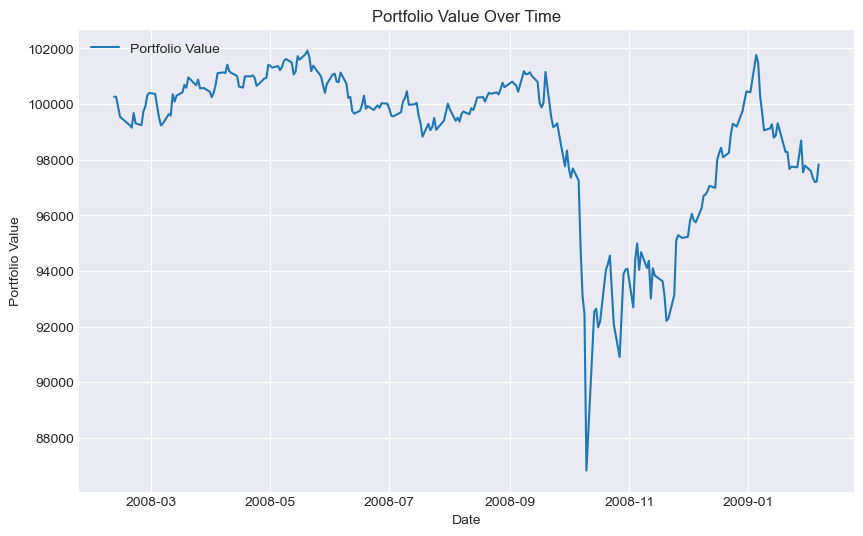

Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: -0.0726
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1317
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0843
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1035
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.0644
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0858
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0803
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0675
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1331
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1207
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1317
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1294
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0878
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0970
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0881
Epoch 16/100
8/8

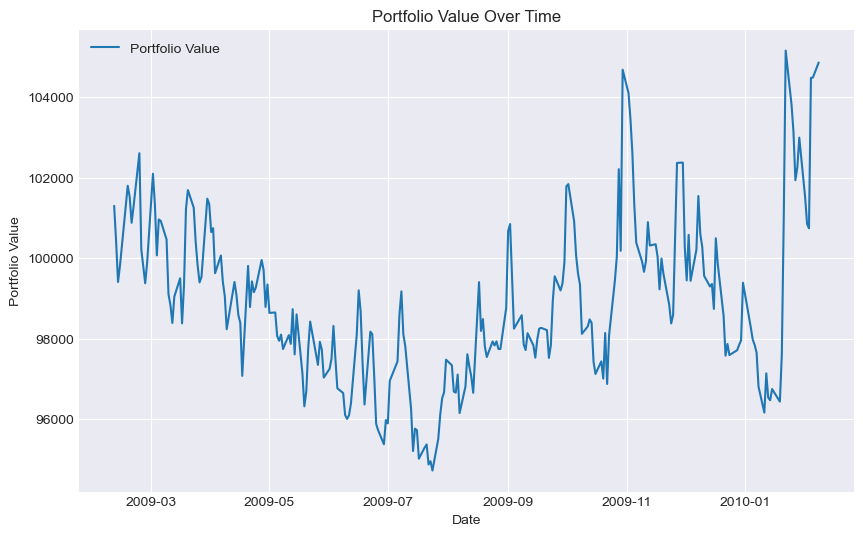

Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0183
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: -0.1052
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0496
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.1178
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: -0.1253
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.0560
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.1460
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: -0.1214
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: -0.0710
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: -0.0827
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1423
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1291
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1180
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0670
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0890
Epoch 16/100
8/8 

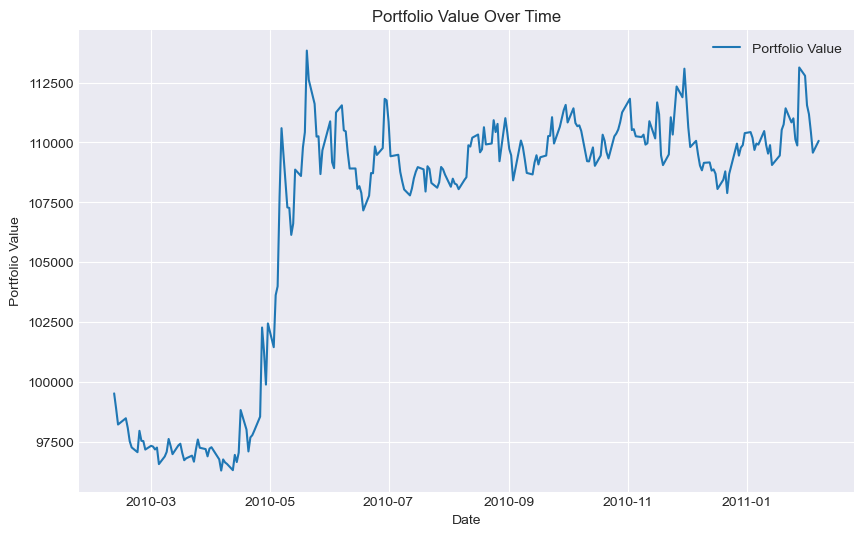

Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: -0.0248
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0296
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0365
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0356
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0428
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0928
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1761
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1857
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1161
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1782
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1501
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1846
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1291
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1773
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1988
Epoch 16/100
8/8 

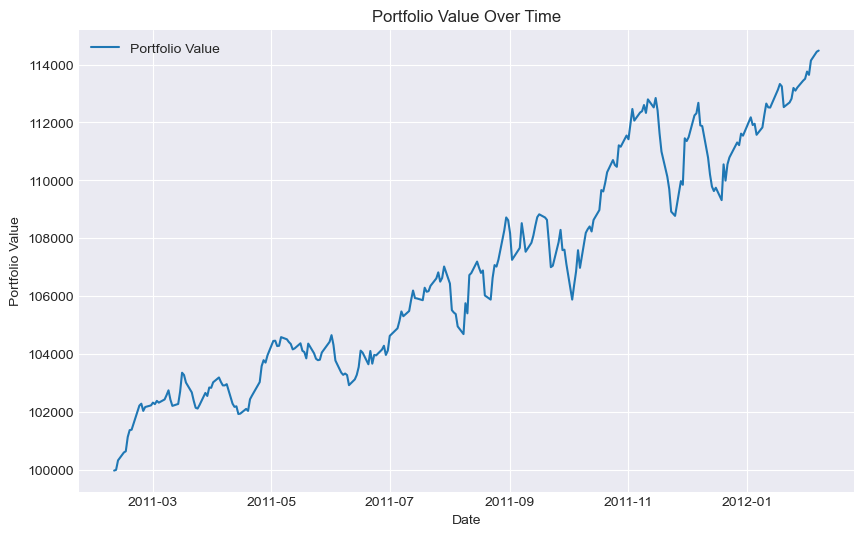

Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0075
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0811
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0742
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1165
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1703
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1484
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1387
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1835
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1309
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2334
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2007
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1973
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2067
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.2545
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1217
Epoch 16/100
8/8 

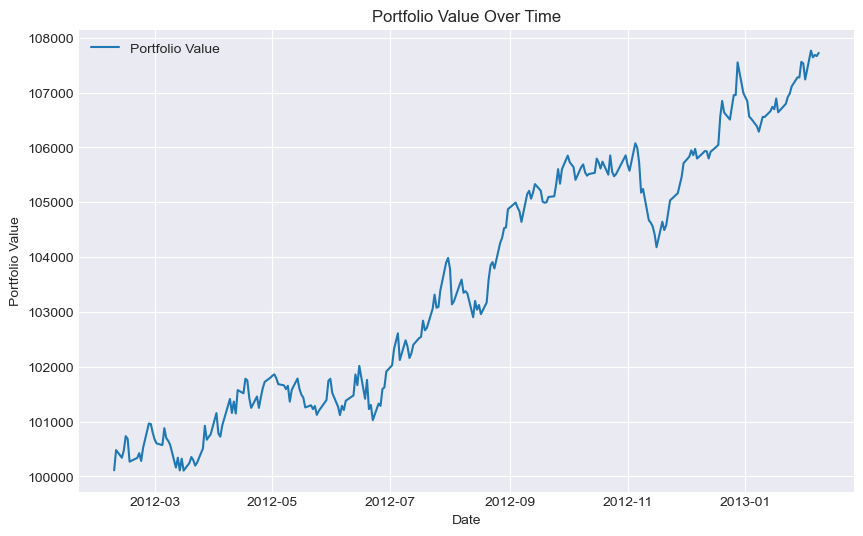

Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -0.1179
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1370
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1169
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0307
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1175
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1639
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1096
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1666
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0733
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0645
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1504
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1137
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0207
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1611
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1207
Epoch 16/100
8/8

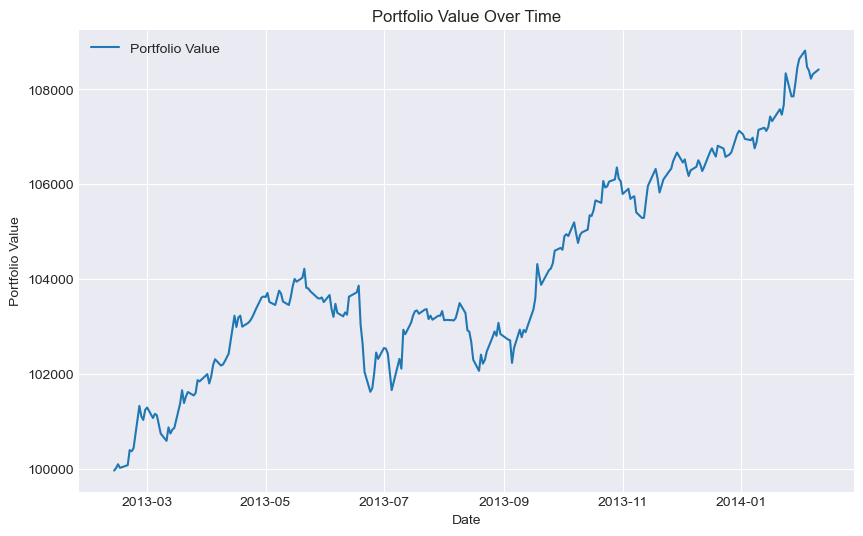

Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: -0.1900
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1326
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1886
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1608
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.2845
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2358
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1947
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2231
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2415
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2377
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2182
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.2171
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.2611
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2069
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2653
Epoch 16/100
8/8

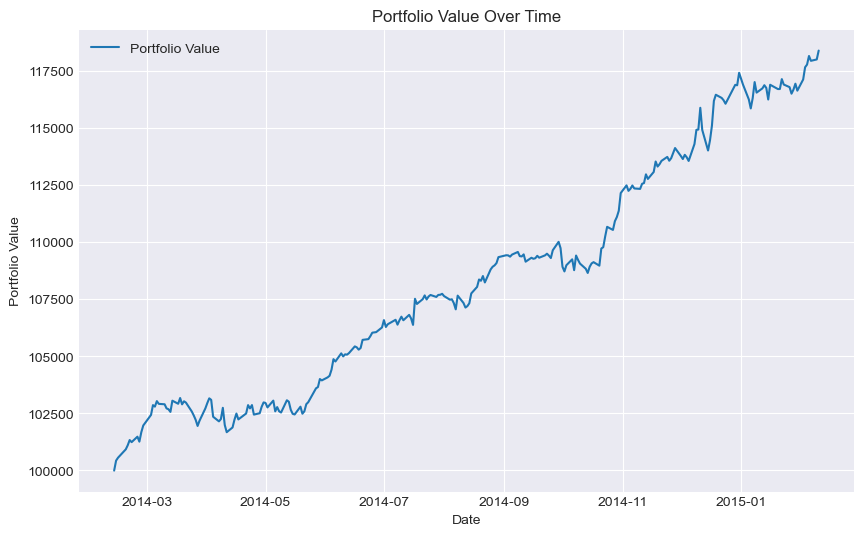

Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: -0.0363
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0699
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0644
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1188
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1669
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: -0.2685 
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2574
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2414
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2438
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1794
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2736
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2655
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2626
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2528
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2139
Epoch 16/100
8/8

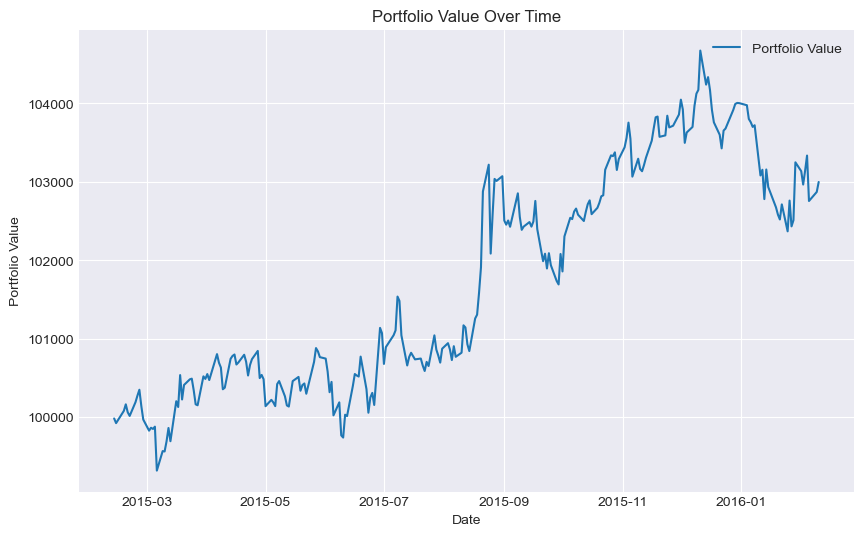

Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: -0.0091
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0730
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0917
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0751
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1079
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1208
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1602
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1066
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0767
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0851
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0947
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1251
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0844
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1570
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.2054
Epoch 16/100
8/8

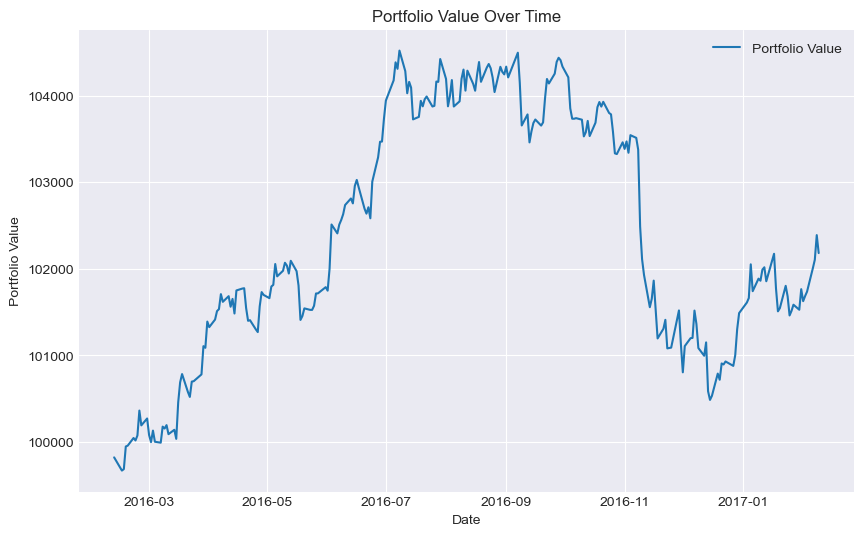

Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: -2.1616e-04
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0392
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0925
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0811
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1236
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1525
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1399
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: -0.1278
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: -0.1802
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2032
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1136
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1781
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1366
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1657
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1796
Epoch 16/100

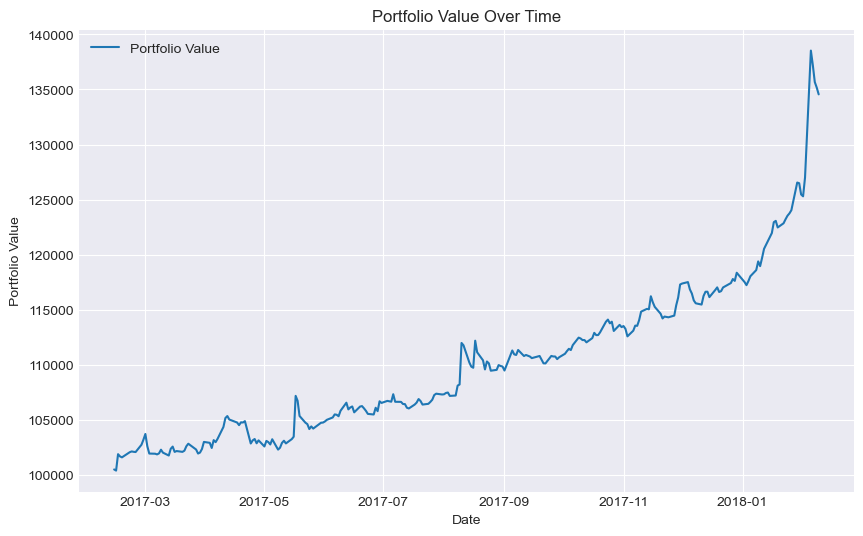

Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -0.0154
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1257
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0838
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1320
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1921
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2003
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2013
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1987
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2254
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2485
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2471
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2514
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2040
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2445
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2205
Epoch 16/100
8/8

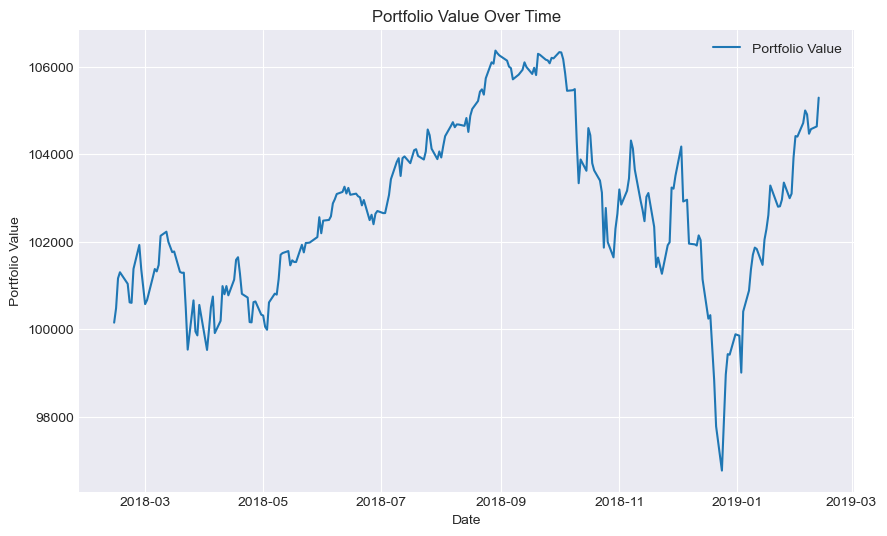

Epoch 1/100


/Users/aryika/anaconda3/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: -0.0459
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0335
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0521
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0215
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.0927
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1146
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1284
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1582
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1301
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1148
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1840
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.1783
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: -0.2174
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1929
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: -0.1875
Epoch 16/100
8/8

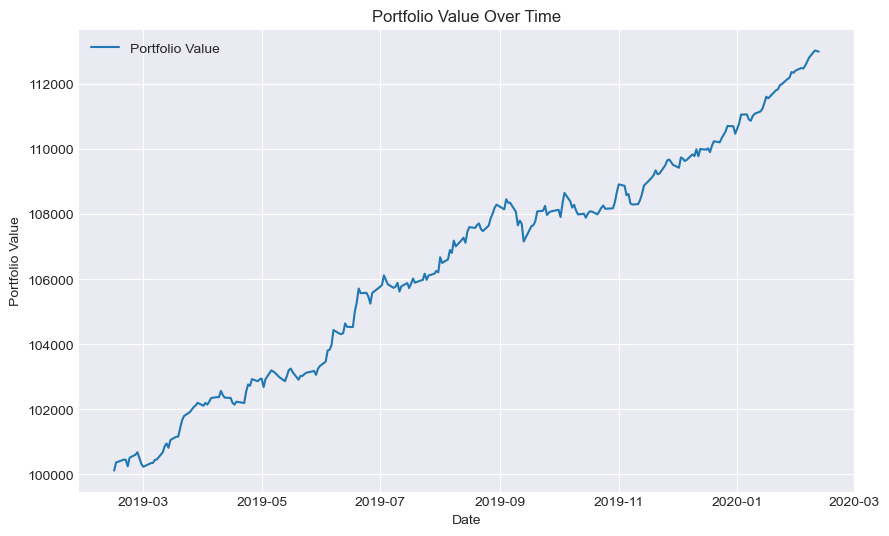

LSTM Results: [{'train_period': (Timestamp('2006-02-06 00:00:00+0000', tz='UTC'), Timestamp('2008-02-07 00:00:00+0000', tz='UTC')), 'test_period': (Timestamp('2008-02-08 00:00:00+0000', tz='UTC'), Timestamp('2009-02-09 00:00:00+0000', tz='UTC')), 'metrics': {'Sharpe Ratio': -0.15156960349212625, 'Sortino Ratio': -0.1668450639345125, 'Max Drawdown': 0.14814977778116623}}, {'train_period': (Timestamp('2007-02-07 00:00:00+0000', tz='UTC'), Timestamp('2009-02-06 00:00:00+0000', tz='UTC')), 'test_period': (Timestamp('2009-02-09 00:00:00+0000', tz='UTC'), Timestamp('2010-02-09 00:00:00+0000', tz='UTC')), 'metrics': {'Sharpe Ratio': 0.29501933749174114, 'Sortino Ratio': 0.6689517855193275, 'Max Drawdown': 0.08137131987338411}}, {'train_period': (Timestamp('2008-02-07 00:00:00+0000', tz='UTC'), Timestamp('2010-02-08 00:00:00+0000', tz='UTC')), 'test_period': (Timestamp('2010-02-09 00:00:00+0000', tz='UTC'), Timestamp('2011-02-08 00:00:00+0000', tz='UTC')), 'metrics': {'Sharpe Ratio': 0.8279766

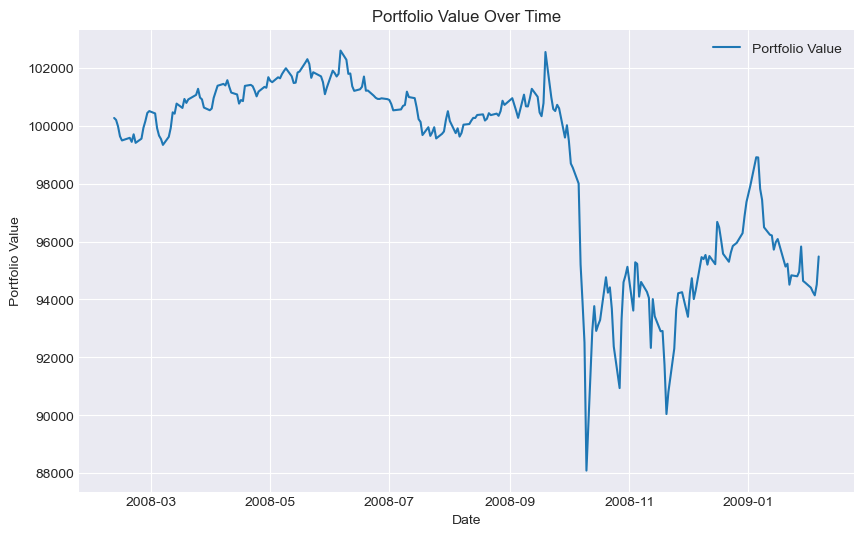

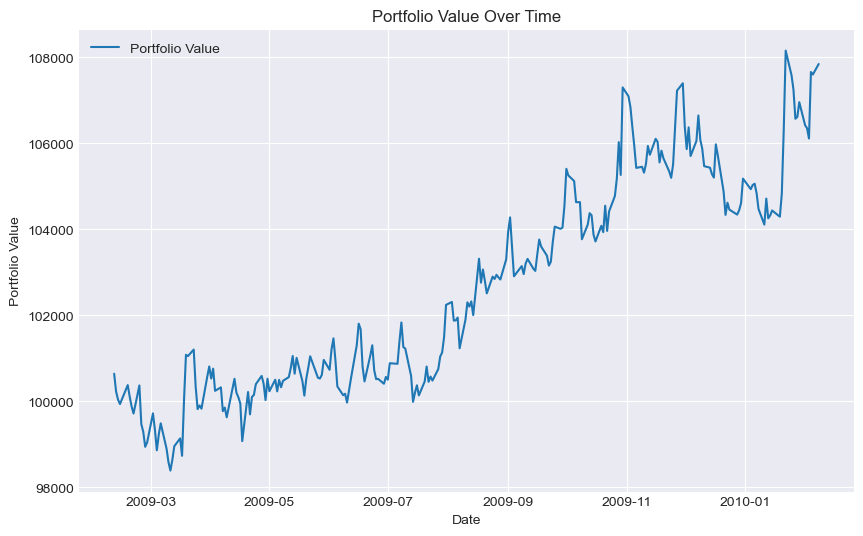

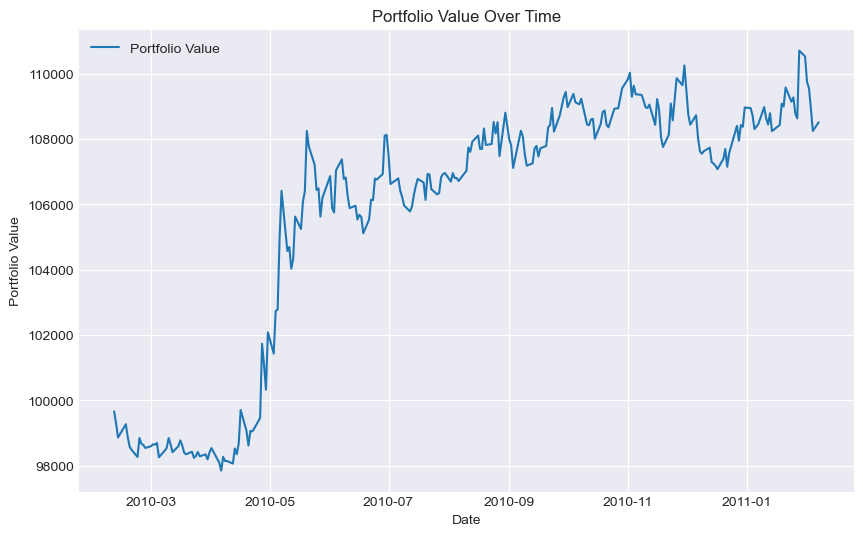

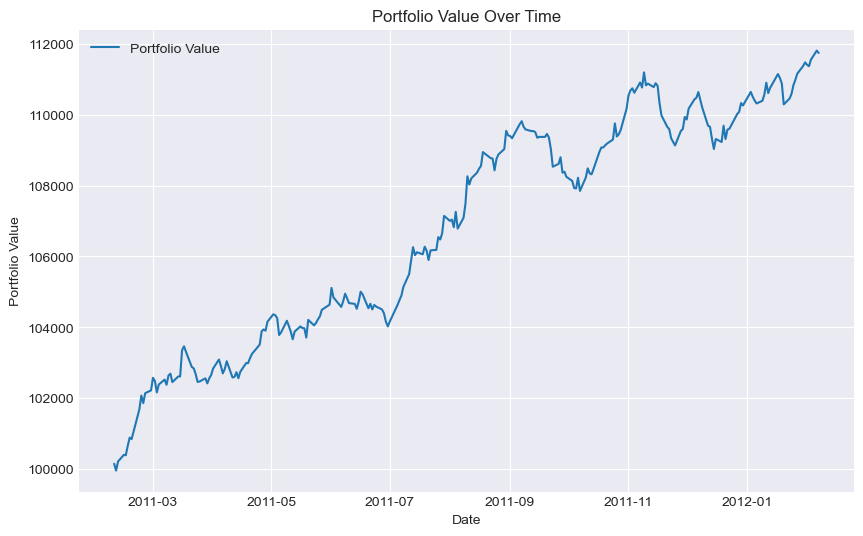

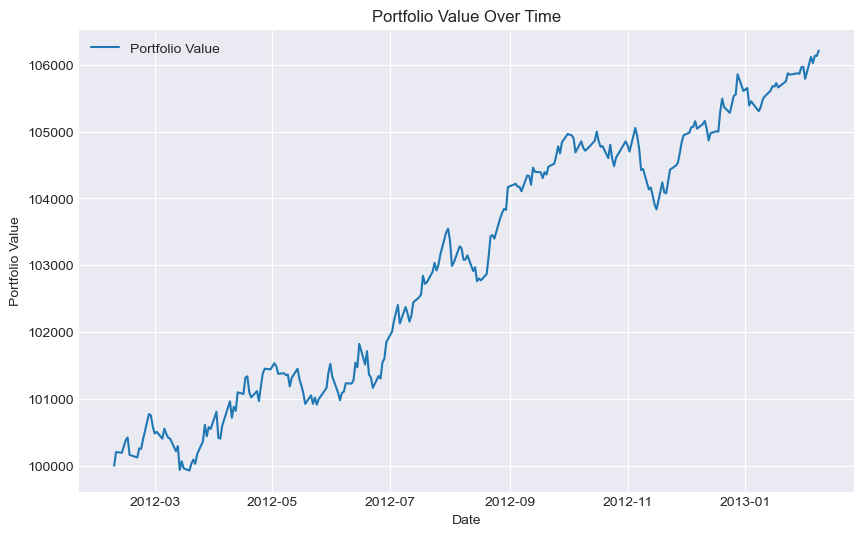

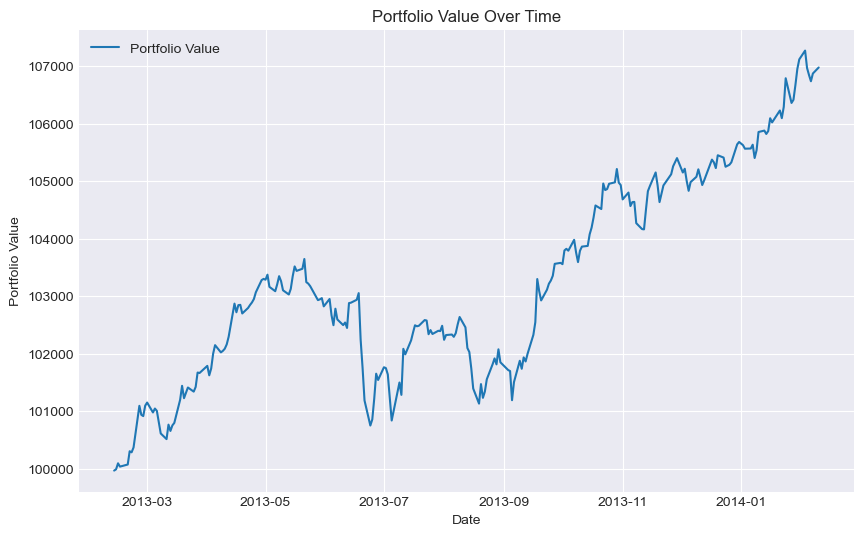

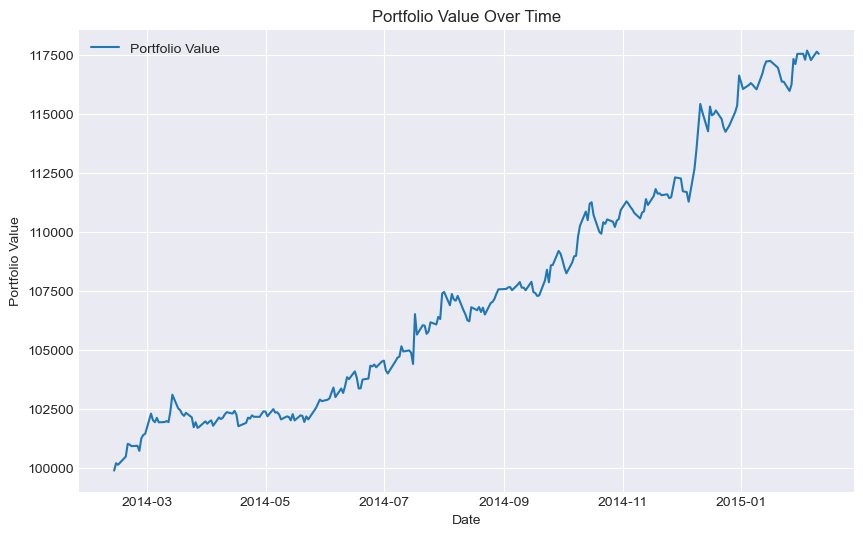

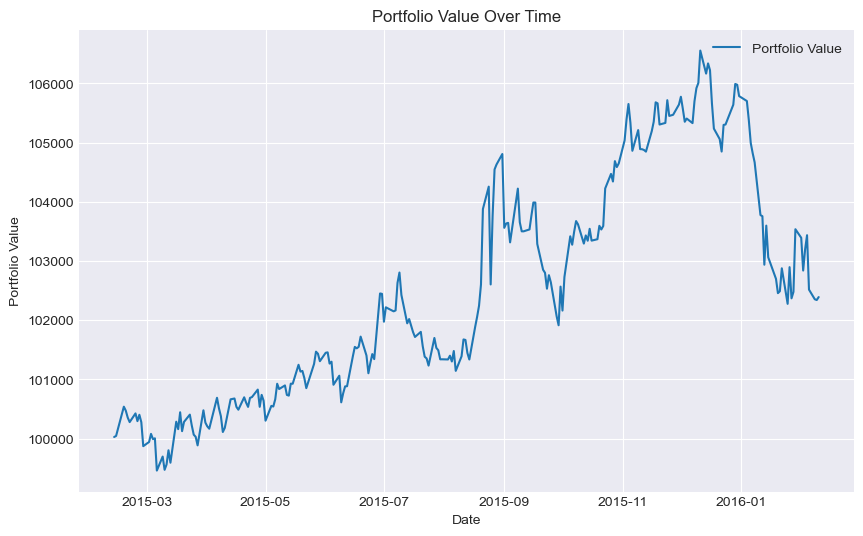

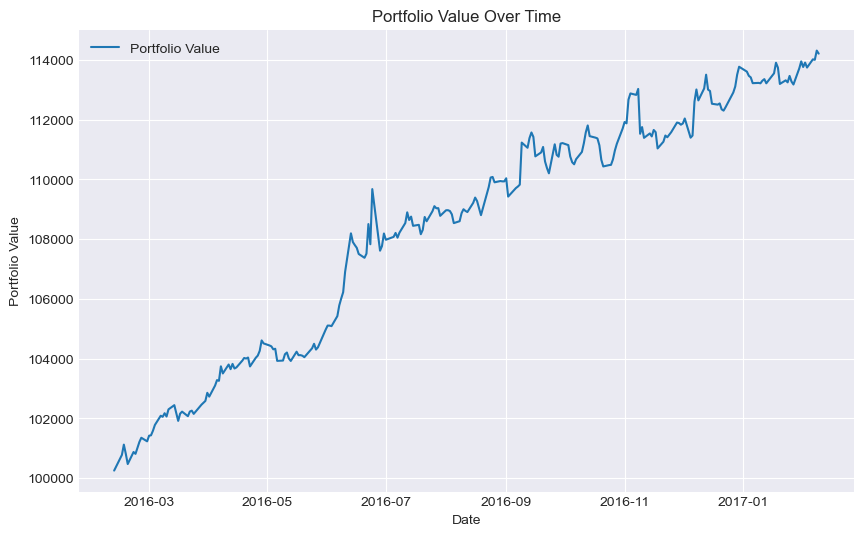

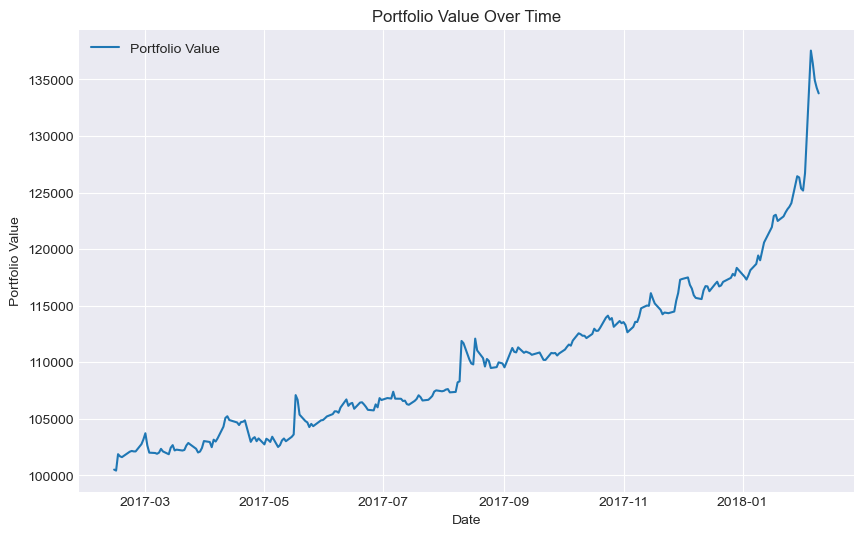

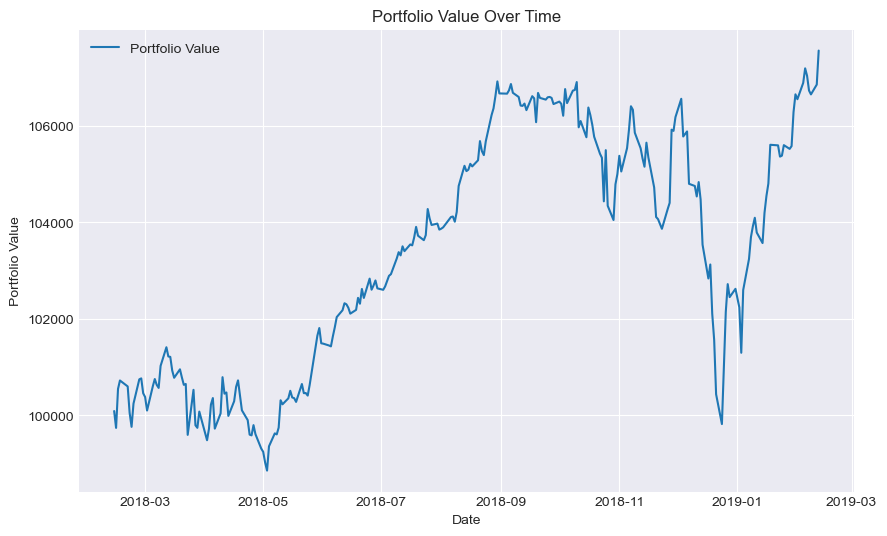

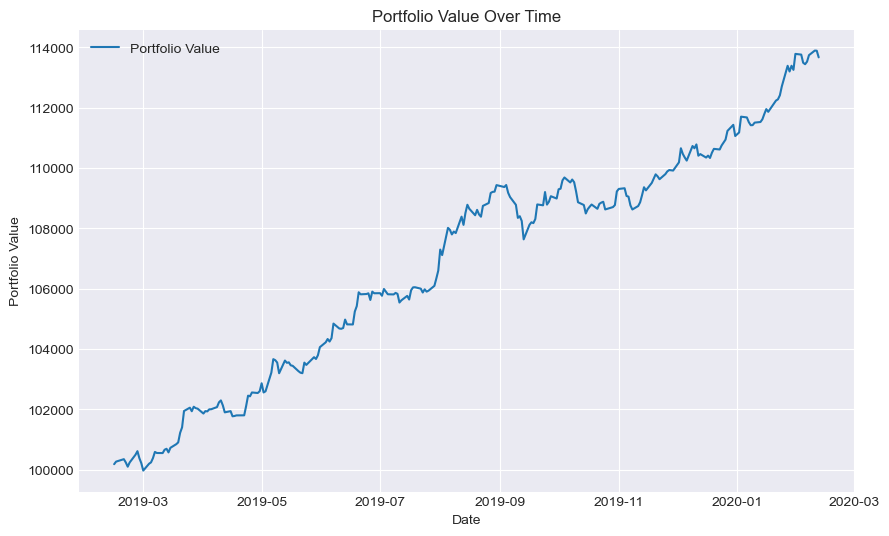

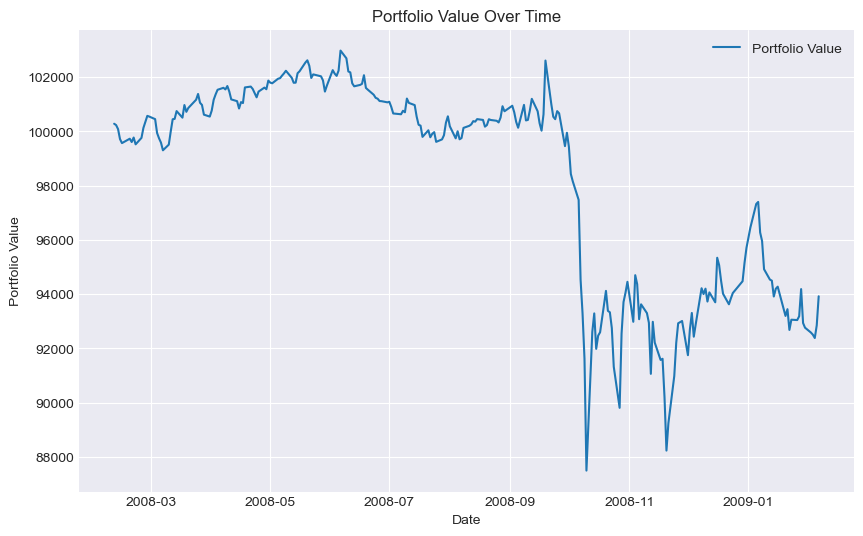

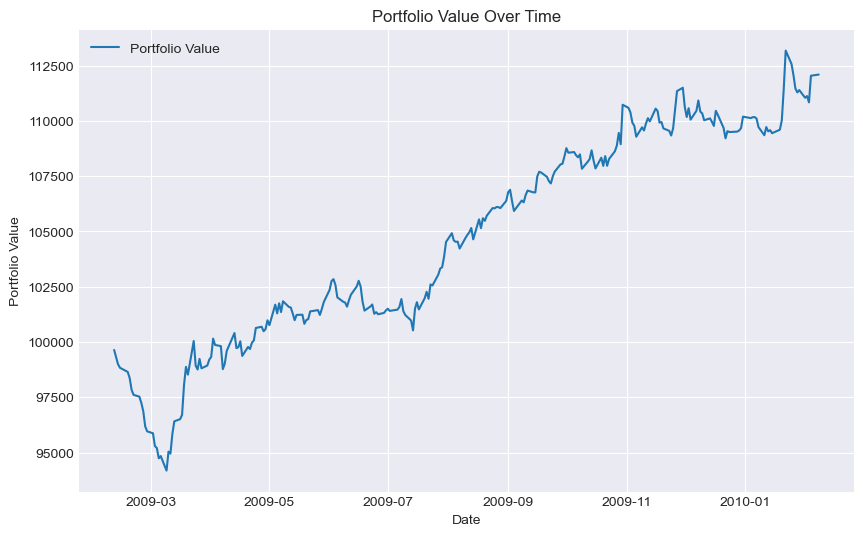

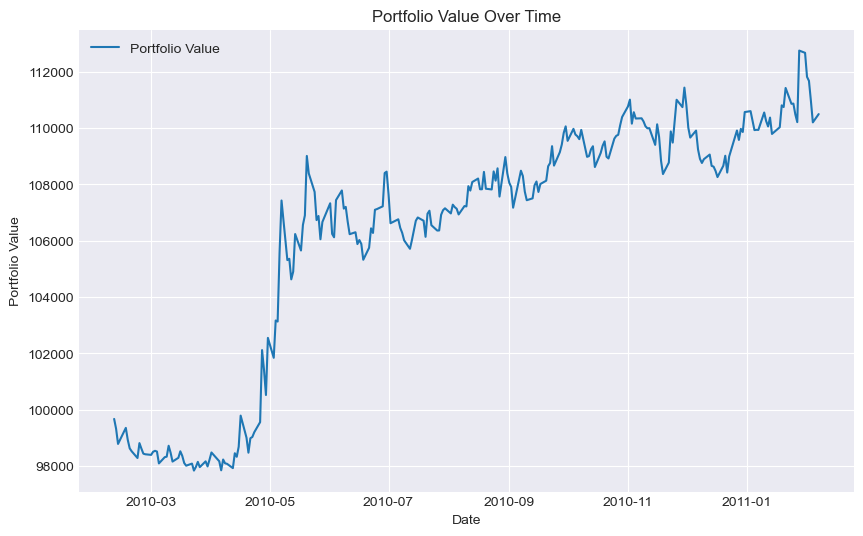

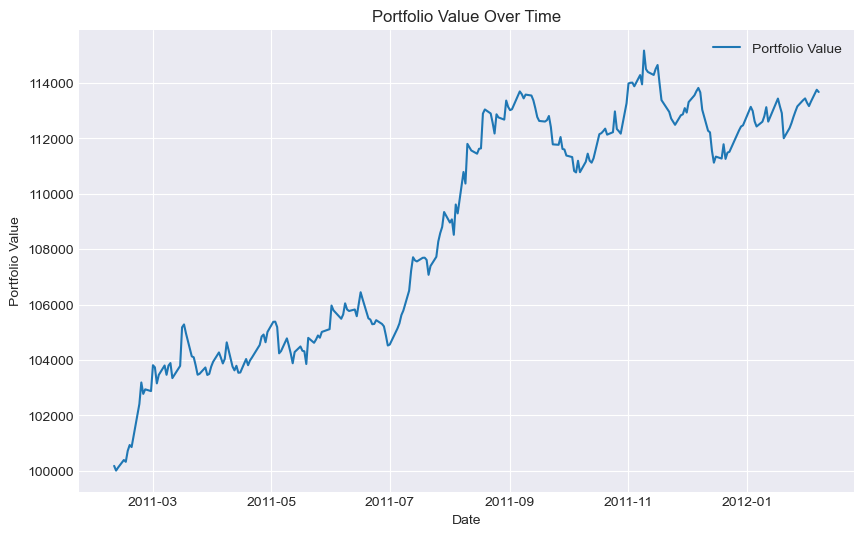

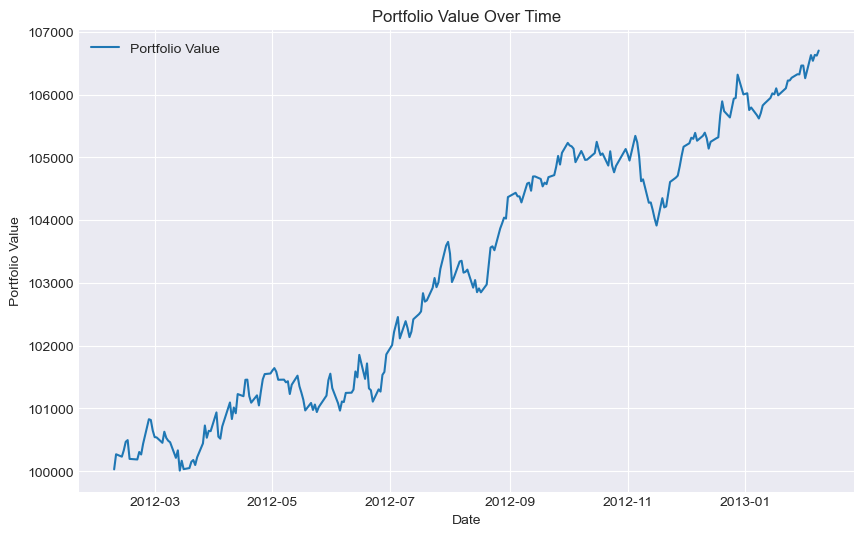

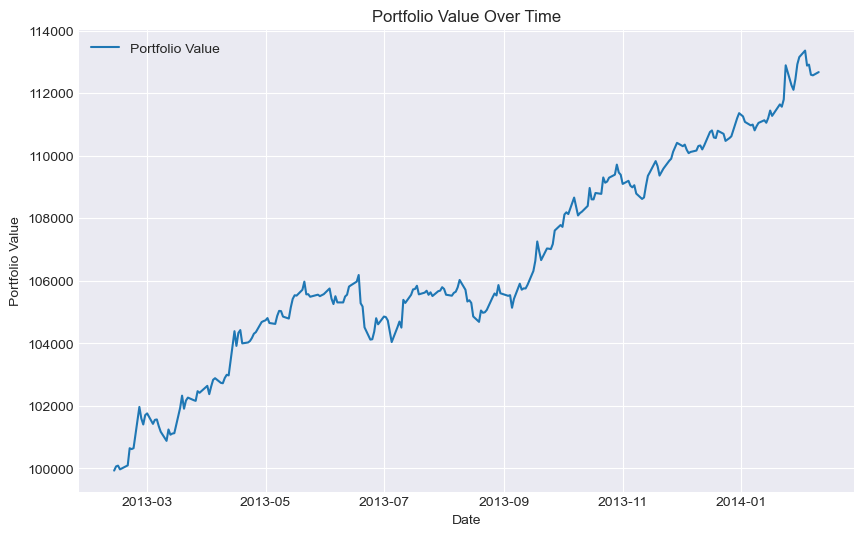

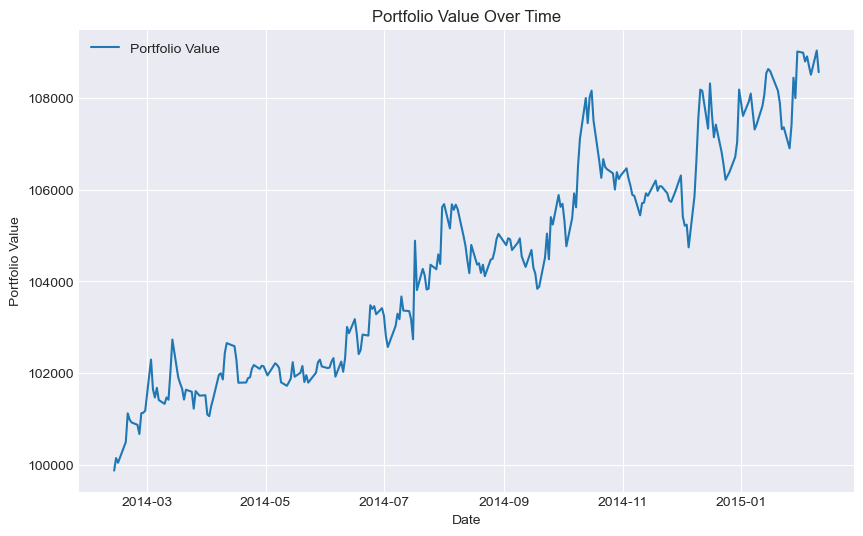

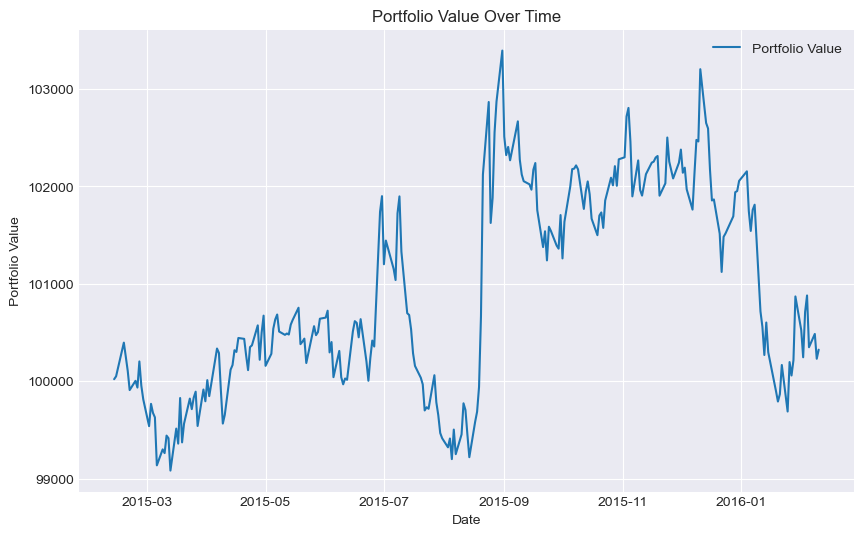

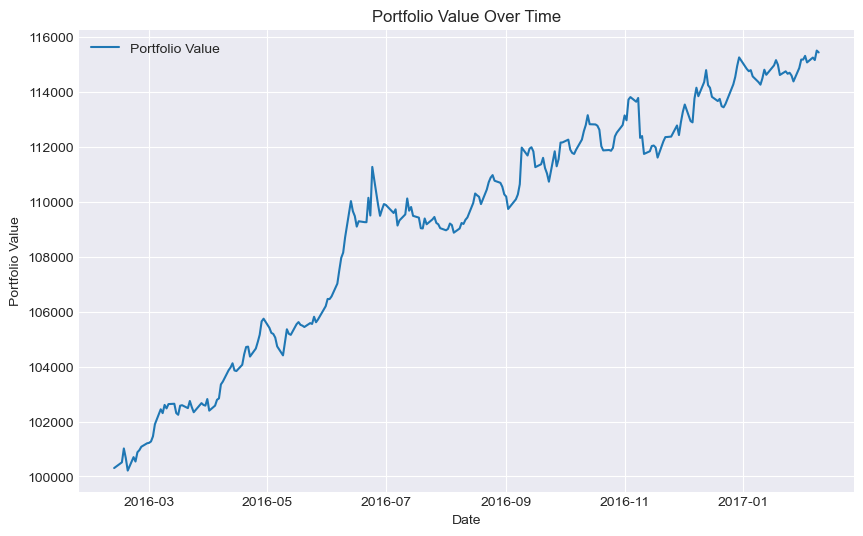

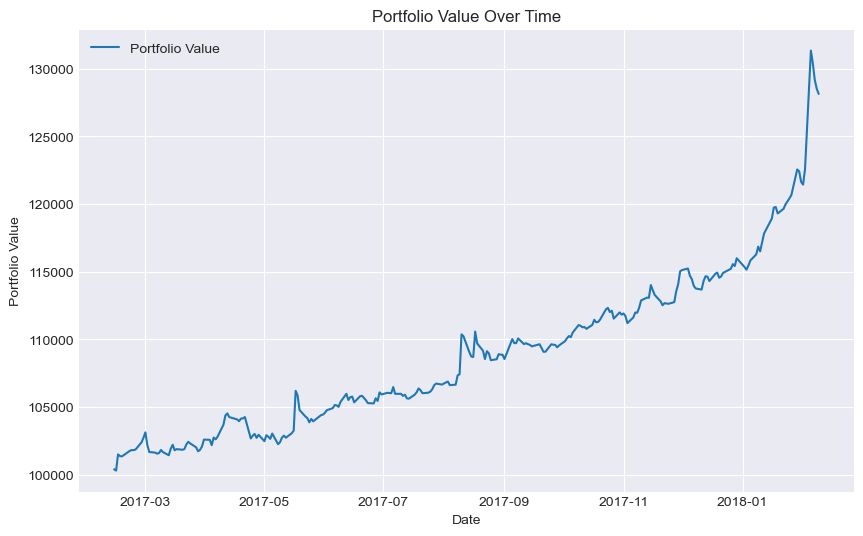

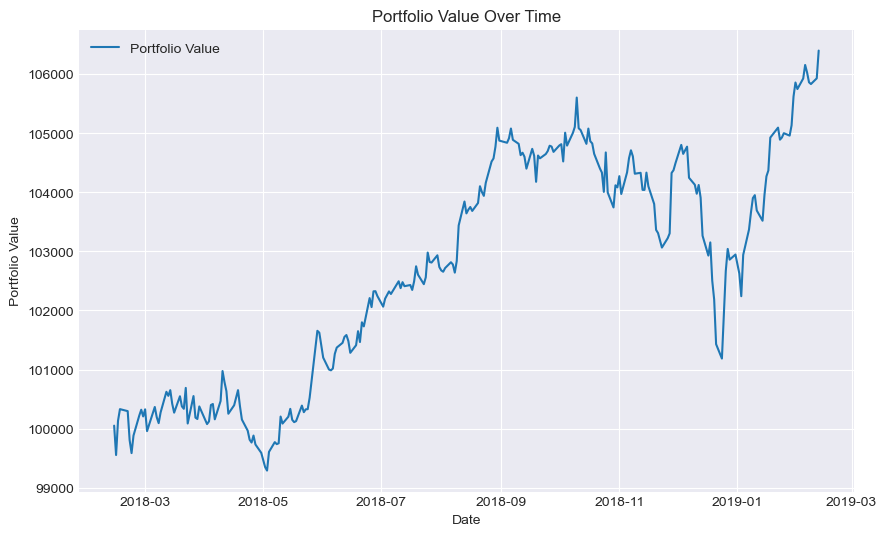

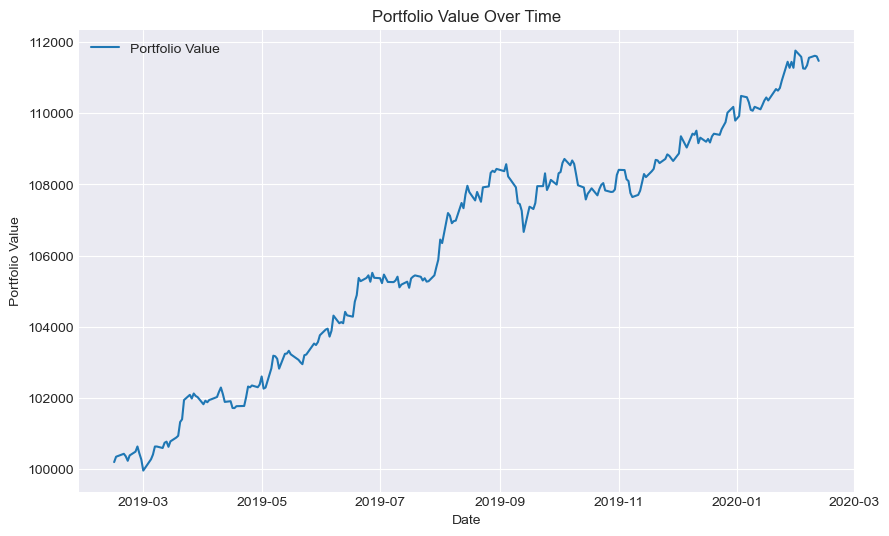

Mean-Variance Optimization Results: [{'train_period': (Timestamp('2006-02-06 00:00:00+0000', tz='UTC'), Timestamp('2008-02-07 00:00:00+0000', tz='UTC')), 'test_period': (Timestamp('2008-02-08 00:00:00+0000', tz='UTC'), Timestamp('2009-02-09 00:00:00+0000', tz='UTC')), 'metrics': {'Sharpe Ratio': -0.3471299814100706, 'Sortino Ratio': -0.43767611943098694, 'Max Drawdown': 0.1414308085385155}}, {'train_period': (Timestamp('2007-02-07 00:00:00+0000', tz='UTC'), Timestamp('2009-02-06 00:00:00+0000', tz='UTC')), 'test_period': (Timestamp('2009-02-09 00:00:00+0000', tz='UTC'), Timestamp('2010-02-09 00:00:00+0000', tz='UTC')), 'metrics': {'Sharpe Ratio': 0.9774995899708122, 'Sortino Ratio': 2.028830596961056, 'Max Drawdown': 0.030599685392126805}}, {'train_period': (Timestamp('2008-02-07 00:00:00+0000', tz='UTC'), Timestamp('2010-02-08 00:00:00+0000', tz='UTC')), 'test_period': (Timestamp('2010-02-09 00:00:00+0000', tz='UTC'), Timestamp('2011-02-08 00:00:00+0000', tz='UTC')), 'metrics': {'Shar

In [20]:
# Define tickers and data parameters
tickers = ['VTI', 'AGG', 'DBC','^VIX']
data = get_data(tickers, '2006-01-01', '2021-01-04')
# Rolling validation with LSTM-based optimization (with periodic rebalancing)
lstm_results,lstm_values = generalized_rolling_validation(data, train_and_rebalance_portfolio)
print("LSTM Results:", lstm_results)
print("Final Portfolio Values:", lstm_values)
# Rolling validation with mean-variance optimization
mvo_results,mvo_values= generalized_rolling_validation(data, mean_variance_optimized_strategy)
# Rolling validation with maximum diversification optimization
md_results,md_values = generalized_rolling_validation(data, maximum_diversification)
print("Mean-Variance Optimization Results:", mvo_results)
print("Final Portfolio Values:", mvo_values)    


In [21]:
diff = [a - b for a, b in zip(lstm_values, mvo_values)]
print(diff)
print("Mean of the difference between LSTM and MVO:", np.mean(diff))
#average profit/average loss, a = final portfolio value for lstm, b = final value for mvo, starting cash = 100000
diff = [a - b for a, b in zip(lstm_values, md_values)]
print(diff)
print("Mean of the difference between LSTM and MD:", np.mean(diff))

# Calculate the average profit/average loss ratio
average_profit = np.mean([a - 100000 for a in lstm_values if a > 100000])
average_loss = 1
average_loss_calc = np.mean([100000 - b for b in mvo_values if b < 100000])
if average_loss_calc != 0:
    average_loss = average_loss_calc
profit_loss_ratio = average_profit / average_loss
print("LSTM profit/loss ratio:", profit_loss_ratio)

average_profit = np.mean([b - 100000 for b in mvo_values if b > 100000])
average_loss = 1
average_loss_calc = np.mean([100000 - b for b in mvo_values if b < 100000])
if average_loss_calc != 0:
    average_loss = average_loss_calc
profit_loss_ratio = average_profit / average_loss
print("MVO profit/loss ratio:", profit_loss_ratio)

average_profit = np.mean([b - 100000 for b in md_values if b > 100000])
average_loss = 1
average_loss_calc = np.mean([100000 - b for b in md_values if b < 100000])
if average_loss_calc != 0:
    average_loss = average_loss_calc
profit_loss_ratio = average_profit / average_loss
print("MD profit/loss ratio:", profit_loss_ratio)


[2349.587552674886, -2984.9650392465846, 1559.4403435572603, 2737.815712683121, 1511.0447824409785, 1446.6232170527073, 845.8456140129274, 607.1344424137642, -12023.128594384121, 785.9508541526448, -2270.734717724874, -668.3715971093334]
Mean of the difference between LSTM and MVO: -508.6464524563853
[3911.139366592397, -7228.86889132623, -426.9083543589659, 811.2079920157703, 1021.0830959442246, -4251.660883484015, 9832.862001331174, 2673.78833621637, -13249.001924499695, 6413.936852770625, -1109.8975120800023, 1527.4259707006713]
Mean of the difference between LSTM and MD: -6.241162514806395
LSTM profit/loss ratio: 2.456290888042545
MVO profit/loss ratio: 2.626514977987239
MD profit/loss ratio: 1.8846651252514461
